In [20]:
import cv2
import caffe
import sys
sys.path.insert(0, './pylayer')
from tool import is_image, load_dict, vec2word, build_voc, write2txt_icdar15_e2e, contain_num, contain_symbol, \
    non_max_suppression
import matplotlib.pyplot as plt
import argparse
import os
import numpy as np
import cfg
import editdistance
%matplotlib inline

In [21]:
print(caffe.__version__)
print(cv2.__version__)

1.0.0
3.4.2


In [22]:
def predict_single(net, input_fea, previous_word):
    cont = 0 if previous_word == 0 else 1
    cont_input = np.array([[cont]])
    word_input = np.array([[previous_word]])
    net.blobs['sample_gt_cont'].reshape(*cont_input.shape)
    net.blobs['sample_gt_cont'].data[...] = cont_input
    net.blobs['sample_gt_label_input'].reshape(*word_input.shape)
    net.blobs['sample_gt_label_input'].data[...] = word_input
    net.blobs['decoder'].reshape(*input_fea.shape)
    net.blobs['decoder'].data[...] = input_fea
    net.forward()
    #net.forward(cont_sel=cont_input, input_sel=word_input, sel_features=input_fea)
    output_preds = net.blobs['probs'].data[0, 0, :]
    return output_preds

def predict_single_from_all_previous(net_lstm, descriptor, previous_words):
    for index, word in enumerate([0] + previous_words):
        res_prob = predict_single(net_lstm, descriptor[[index]], word)
    return res_prob




def forward_iou(im, net_iou, resize_length, mask_th):
    h, w, c = im.shape
    scale = max(h, w) / float(resize_length)

    image_resize_height = int(round(h / scale / 32) * 32)
    image_resize_width = int(round(w / scale / 32) * 32)
    scale_h = float(h) / image_resize_height
    scale_w = float(w) / image_resize_width
    im = cv2.resize(im, (image_resize_width, image_resize_height))
    im = np.asarray(im, dtype=np.float32)
    im = im - cfg.mean_val
    im = np.transpose(im, (2, 0, 1))
    im = im[np.newaxis, :]

    net_iou.blobs['data'].reshape(*im.shape)
    net_iou.blobs['data'].data[...] = im


    fcn_th_blob = np.zeros((1, 1), dtype=np.float32)
    fcn_th_blob[0, 0] = mask_th
    net_iou.blobs['fcn_th'].reshape(*fcn_th_blob.shape)
    net_iou.blobs['fcn_th'].data[...] = fcn_th_blob
    net_iou.forward()

    det_bboxes = net_iou.blobs['rois'].data[:, 1:].copy()

    det_bboxes[:, :8:2] = det_bboxes[:, :8:2] * scale_w
    det_bboxes[:, 1:8:2] = det_bboxes[:, 1:8:2] * scale_h

    decoder_reg = net_iou.blobs['decoder'].data
    return det_bboxes, decoder_reg



def forward_reg(decoder_rec, net_rec, det_bboxes, recog_th=0.85):
    boxes = list()
    words = list()
    words_score = list()
    det_num = det_bboxes.shape[0]
    if not (det_bboxes > 0).any():
        det_num = 0
    for i in range(det_num):
        previous_words = []
        score = []
        if not (det_bboxes[i] > 0).any():
            continue
        for t in range(cfg.max_len):
            input_fea = decoder_rec[:t + 1, i, :]
            input_fea = np.reshape(input_fea, (t + 1, 1, -1))
            net_rec.blobs['sample_gt_cont'].reshape(1, 1)
            net_rec.blobs['sample_gt_label_input'].reshape(1, 1)
            net_rec.blobs['decoder'].reshape(*input_fea.shape)
            res_probs = predict_single_from_all_previous(net_rec, input_fea, previous_words)
            ind = np.argmax(res_probs)

            if ind == 0:
                break
            else:
                previous_words.append(ind)
                score.append(res_probs[ind])

        if len(score) > 0:
            print float(sum(score)) / len(score), vec2word(previous_words, dicts)
            if float(sum(score)) / len(score) < recog_th:
                continue
            tmp = det_bboxes[i].copy().tolist()
            # tmp[-1]+=float(sum(score)) / len(score) * 2
            boxes.append(tmp)
            words.append(vec2word(previous_words, dicts))
            words_score.append(float(sum(score)) / len(score))

    return boxes, words, words_score

In [23]:
args = {
    "weight": "./models/textspotter.caffemodel",
    "prototxt_iou": "./models/test_iou.pt",
    "prototxt_lstm": "./models/test_lstm.pt",
    "thresholds": "0.95, 0.95, 0.95, 0.95",
    "scales": "2240, 1920, 1792, 2080",
    "img": "./imgs",
    "nms": 0.2,
    "save_dir": "./results"
}

./imgs/ab749691-c451-4b0c-a076-52570a29f327-1514585711415-85633P9X+XQV6.jpg
1 / 4:  ./imgs/ab749691-c451-4b0c-a076-52570a29f327-1514585711415-85633P9X+XQV6.jpg
0.999992983682 parking
0.999986663461 stopping
0.956087369185 anti-gridlock
0.847574225494 abirmer
0.99705974261 6pm
0.999245524406 no
0.8826610744 9ams
0.999995648861 hour
0.993502795696 9am
0.999445617199 2
0.955597631633 refcover
0.838489075502 zam
0.99970652163 zone
0.953379797935 impbunoto'
0.967392489314 saturday
0.979408204556 to
0.740328665291 jewicce
0.724529720843 caur
0.999855905771 to
0.987540245056 xcept
0.789825239778 skeep
0.910794113364 saturra
0.976088533799 sunday
0.763734847307 343-1
0.997361520926 sonday
0.873654037714 b070
0.999987334013 stopping
0.999992336546 parking
0.834029495716 game
0.998031646013 no
0.905901759863 anti-gridlorr
0.99604678154 6pm
0.793853034576 zam
0.999996006489 hour
0.992102007071 9am
0.993328511715 zone
0.999351799488 2
0.667164444923 yan
0.918219842017 mpdunoto
0.943082196372 recov

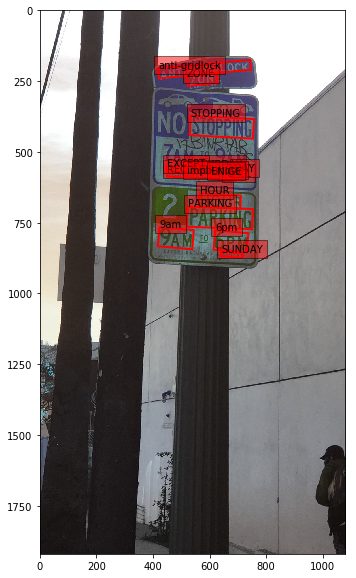

./imgs/03673a00-ef23-11e7-903b-8d9a8c07e4d0-1515027633246-85633WH4+XJX6-164.268890380859.jpg
2 / 4:  ./imgs/03673a00-ef23-11e7-903b-8d9a8c07e4d0-1515027633246-85633WH4+XJX6-164.268890380859.jpg
0.999442032405 parking
0.999925211072 hour
0.978863656521 spm
0.944441449642 6a.m.
0.33242174983 c
0.998757849137 except
0.731973767281 to
0.999963257994 parking
0.999809429049 hour
0.955910483996 6pm
0.992478966713 6a.m
0.671897351742 2
0.996882150571 except
0.999841451645 to
0.911324302355 ounday
0.999892388071 parking
0.999452367425 hour
0.954094544053 6pm.
0.326845645905 c
0.994180178642 6a.m.
0.999757945538 to
0.986906449 except
0.999953567982 parking
0.977717876434 spm.
0.99991312623 hour
0.973554384708 6a.m.
0.683669090271 2
0.988012293975 except
0.99979481101 to


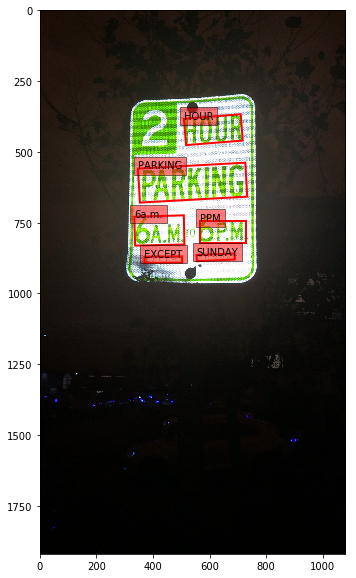

./imgs/img_105.jpg
3 / 4:  ./imgs/img_105.jpg
0.997899077833 queueing
0.999932658672 thank
0.999995668729 you
0.999997814496 for
0.999944150448 thank
0.998694501817 queueing
0.999992330869 you
0.999997973442 for
0.998780608177 queueing
0.999951720238 thank
0.999997496605 you
0.99999721845 for
0.998085334897 queueing
0.999950170517 thank
0.999996383985 you
0.999997615814 for


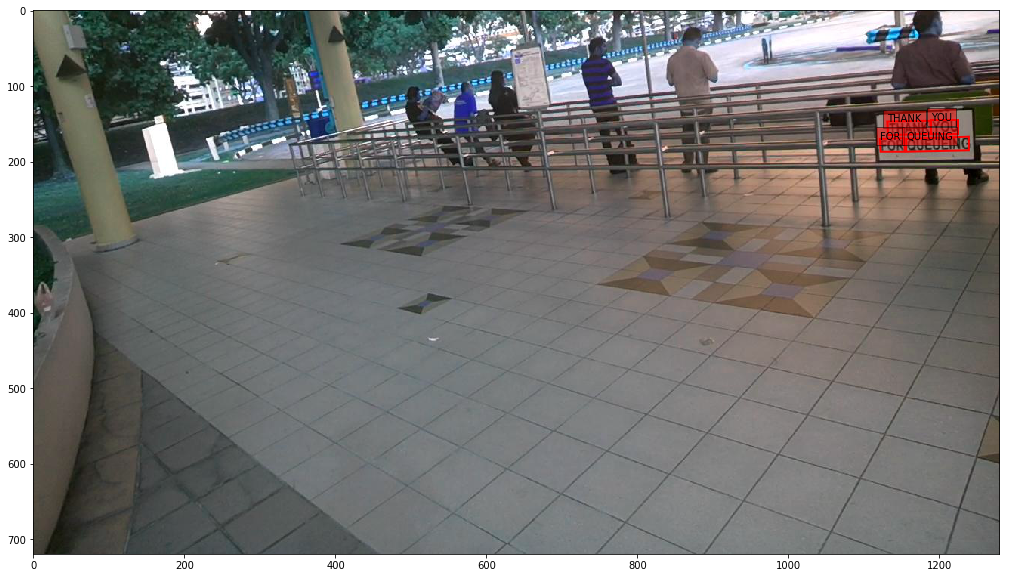

./imgs/ab749691-c451-4b0c-a076-52570a29f327-1514495205707-85634VR9+G423.jpg
4 / 4:  ./imgs/ab749691-c451-4b0c-a076-52570a29f327-1514495205707-85634VR9+G423.jpg
0.999993511609 parking
0.999996483326 minute
0.99996872743 monday
0.999981840452 friday
0.99836204946 11am
0.999980619975 parking
0.545953273773 2
0.998553872108 2pm
0.947183310986 to
0.999989475523 parking
0.982432385286 bonday
0.930724660556 6am
0.964593529701 friday
0.999893426895 city
0.965161144733 to
0.998613804579 no
0.949434975783 2am
0.846480727196 nars
0.999652028084 wide
0.996910075347 minute
0.999638229609 city
0.693288785219 le2ph
0.88271792233 skin
0.973310500383 hair
0.986683428288 3
0.999992047037 parking
0.999925424655 monday
0.999942590793 friday
0.99999721845 minute
0.998790999254 1am
0.999931020396 parking
0.873919487 3
0.997926076253 2pm
0.999987551144 parking
0.998911350965 to
0.972362438838 manday
0.994085460901 friday
0.998218973478 minute
0.995405465364 no
0.917582273483 6am
0.998408600688 wide
0.7710687

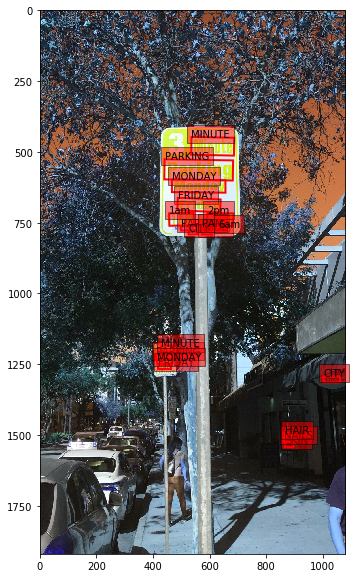

In [24]:
if not os.path.exists(args["prototxt_iou"]) or \
    not os.path.exists(args["prototxt_lstm"]) or \
    not os.path.exists(args["weight"]):
    assert False, 'please put model and prototxts in ./model/'

imgs_files = []
if os.path.isdir(args["img"]):
    imgs = os.listdir(args["img"])
    imgs_files = [args["img"]+"/"+_ for _ in imgs if is_image(_)]
elif os.path.isfile(args["img"]):
    imgs = [args["img"]]
    imgs_files = [_ for _ in imgs if is_image(_)]
else:
    assert False, 'invalid input image (folder)'

if len(imgs_files) == 0:
    assert False, 'invalid input image (folder)'

if not os.path.exists(args["save_dir"]):
    os.mkdir(args["save_dir"])


caffe.set_mode_gpu()
caffe.set_device(0)

net_iou = caffe.Net(args["prototxt_iou"], args["weight"], caffe.TEST)
net_rec = caffe.Net(args["prototxt_lstm"], args["weight"], caffe.TEST)

thresholds = [float(_) for _ in args["thresholds"].strip().split(',')]
scales = [int(_) for _ in args["scales"].strip().split(',')]

assert len(thresholds) == len(scales), \
    'the length of thresholds and scales should be equal'

### get vocabulary
generic_voc_file = './dicts/generic_lex.txt'
generic_vocs = load_dict(generic_voc_file)

dicts = build_voc('./dicts/dict.txt')

### forward single image
for ind, image_name in enumerate(imgs_files):
    print(image_name)
    new_boxes = np.zeros((0, 9))
    words = np.zeros(0)
    words_score = np.zeros(0)
    image_id = image_name.split('/')[-1].split('.')[0]
    print '%d / %d: ' % (ind+1, len(imgs_files)), image_name
    im = cv2.imread(image_name)
    h, w, c = im.shape
    ### forward every scale
    for k in range(len(scales)):
        image_resize_length = scales[k]
        mask_threshold = thresholds[k]
        det_bboxes, decoder_rec = forward_iou(im, net_iou, image_resize_length, mask_threshold)
        det_num = det_bboxes.shape[0]
        #new_boxes, words, words_score = forward_reg(decoder_rec, net_rec, det_bboxes, cfg.recog_th)
        boxes_k, words_k, words_score_k = forward_reg(decoder_rec, net_rec, det_bboxes, cfg.recog_th)
        if len(boxes_k) > 0:
            new_boxes = np.concatenate([new_boxes, np.array(boxes_k)], axis=0)
            words = np.concatenate([words, np.array(words_k)])
            words_score = np.concatenate([words_score, np.array(words_score_k)])



    if len(new_boxes) == 0:
        out_name = os.path.join(args["save_dir"], 'res_' + image_id + '.txt')
        new_boxes = np.zeros((0, 8))
        words = np.zeros((0, 8))
        write2txt_icdar15_e2e(out_name, new_boxes, words)
    else:
        new_boxes = np.array(new_boxes)
        new_boxes = np.reshape(new_boxes, [-1,9])
        words = np.array(words)
        words_score = np.array(words_score)
        assert new_boxes.shape[1] == 9
        assert len(new_boxes) == len(words)
        assert len(new_boxes) == len(words_score)


        final_box = list()
        final_words = list()
        final_words_score = list()
        for n in range(new_boxes.shape[0]):
            word = words[n]
            if len(word) < 3:
                continue
            if (contain_num(word) or contain_symbol(word)) and words_score[n] > cfg.word_score:
                final_box.append(new_boxes[n])
                final_words.append(words[n])
                final_words_score.append(words_score[n])
                # symbol_or_num = 1
                continue

            distance = list()
            score = words_score[n]
            for cell in generic_vocs:
                # dist = levenshteinDistance(word.upper(), cell.upper())
                dist = editdistance.eval(word.upper(), cell.upper())
                distance.append(dist)
                if dist == 0 and words_score[n] > 0.85:
                    score = 1.1
                    #    break
            ind = int(np.argmin(np.array(distance)))
            if (distance[ind] > 1 or score < 0.9):
                continue
            # if (distance[ind] > 3 or score < 0.9) and has_symbol==1:
            #	continue
            final_box.append(new_boxes[n])
            final_words.append(generic_vocs[ind])
            final_words_score.append(score)

        final_box = np.array(final_box).reshape(-1, 9)
        final_words = np.array(final_words)
        final_words_score = np.array(final_words_score)
        final_box[:, -1] = 2 * final_box[:, -1] + final_words_score
        keep_indices, temp_boxes = non_max_suppression(final_box, args["nms"])
        keep_indices = np.int32(keep_indices)

        temp_boxes = final_box[keep_indices]
        temp_words = final_words[keep_indices]

        for index in range(len(keep_indices)):
            for i in range(4):
                temp_boxes[index][2 * i] = int(round(temp_boxes[index][2 * i]))
                temp_boxes[index][2 * i] = max(0, temp_boxes[index][2 * i])
                temp_boxes[index][2 * i] = min(w - 1, temp_boxes[index][2 * i])
                temp_boxes[index][2 * i + 1] = int(round(temp_boxes[index][2 * i + 1]))
                temp_boxes[index][2 * i + 1] = max(0, temp_boxes[index][2 * i + 1])
                temp_boxes[index][2 * i + 1] = min(h - 1, temp_boxes[index][2 * i + 1])

        out_name = os.path.join(args["save_dir"], 'res_' + image_id + '.txt')
        write2txt_icdar15_e2e(out_name, temp_boxes, temp_words)

        ### show results
        plt.figure(figsize=(20,10))
        plt.imshow(im)
        # print image_resize_width, image_resize_height
        currentAxis = plt.gca()
        colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
        for n in range(len(temp_boxes)):
            coords = np.reshape(temp_boxes[n, 0:8], (-1, 2))
            currentAxis.add_patch(plt.Polygon(coords, fill=False, edgecolor=colors[0], linewidth=2))
            currentAxis.text(coords[0][0], coords[0][1], temp_words[n],
                             bbox={'facecolor': (1, 0, 0), 'alpha': 0.5})

        plt.show()